In [ ]:
pip install psx-data-reader

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import math
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings('ignore')

In [ ]:
df=pd.read_csv('/content/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [ ]:
df.head(5)

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

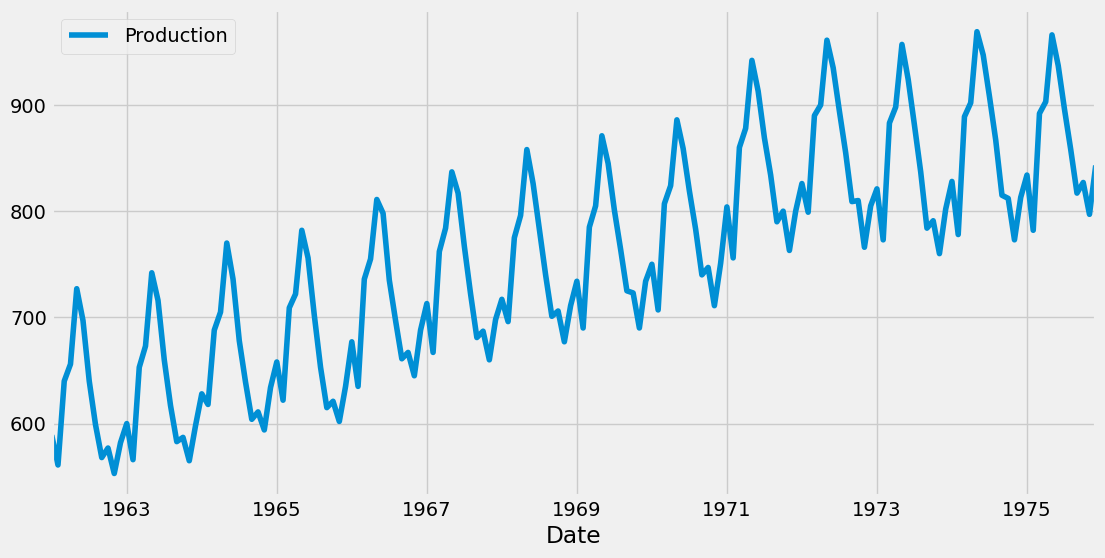

In [ ]:
df.plot(figsize=(12,6))

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


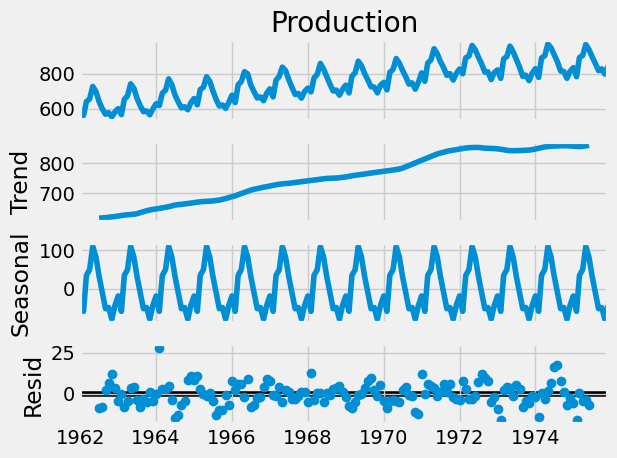

In [ ]:
result=seasonal_decompose(df['Production'])
result.plot();

In [ ]:
len(df)

168

In [ ]:
train=df.iloc[:156]
test=df.iloc[156:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler()

In [ ]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [ ]:
scalar.fit(train)
scaled_train=scalar.transform(train)
scaled_test=scalar.transform(test)

In [ ]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
#define generator
n_input=3
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [ ]:
print(len(scaled_train),len(generator))

156 153


In [ ]:
X,y=generator[0]
print(f'given the Array: \n{X.flatten()}')
print(f'Predict this y: \n{y}')


given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
[[0.24759615]]


In [ ]:
X.shape

(1, 3, 1)

In [ ]:
#we do the same thing but now instead for 12 months
n_input=12
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
#define model
model=Sequential()
model.add(LSTM(100,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 4s 9ms/step - loss: 0.0567
Epoch 2/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0218
Epoch 3/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0178
Epoch 4/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0143
Epoch 5/50
144/144 [==============================] - 3s 19ms/step - loss: 0.0106
Epoch 6/50
144/144 [==============================] - 3s 23ms/step - loss: 0.0061
Epoch 7/50
144/144 [==============================] - 2s 14ms/step - loss: 0.0050
Epoch 8/50
144/144 [==============================] - 1s 10ms/step - loss: 0.0041
Epoch 9/50
144/144 [==============================] - 2s 14ms/step - loss: 0.0037
Epoch 10/50
144/144 [==============================] - 2s 11ms/step - loss: 0.0059
Epoch 11/50
144/144 [==============================] - 2s 16ms/step - loss: 0.0041
Epoch 12/50
144/144 [==============================] - 2s 16ms/step - loss: 0.0051
Epoch 13/50
14

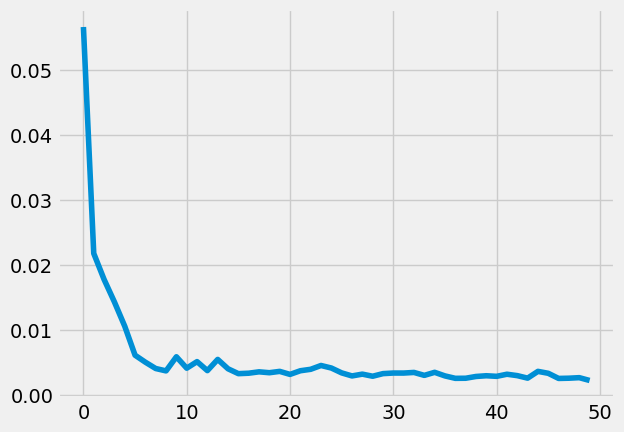

In [ ]:
loss_per_epoch=model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch=scaled_train[-12:]


In [ ]:
if last_train_batch.size > 0:
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
else:
    print("Error: The array is empty.")

In [ ]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 318ms/step


array([[0.6597382]], dtype=float32)

In [ ]:
scaled_test[0]

array([0.67548077])

In [ ]:
test_predictions=[]

first_eval_batch=scaled_train[-n_input:]
current_batch=first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
  #get prediction value for the first batch
  current_pred=model.predict(current_batch)[0]

  #append the prediction into the array
  test_predictions.append(current_pred)

  #use the prediction to update the batch and remove the first value
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


1/1 [==============================] - 0s 100ms/step


In [ ]:
test_predictions

[array([0.6597382], dtype=float32),
 array([0.6639249], dtype=float32),
 array([0.8627995], dtype=float32),
 array([0.9541622], dtype=float32),
 array([1.0735161], dtype=float32),
 array([1.0515894], dtype=float32),
 array([0.95791185], dtype=float32),
 array([0.83010143], dtype=float32),
 array([0.7123159], dtype=float32),
 array([0.65863794], dtype=float32),
 array([0.6112265], dtype=float32),
 array([0.6396613], dtype=float32)]

In [ ]:
test.head()

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966


In [ ]:
true_predictions=scalar.inverse_transform(test_predictions)

In [ ]:
test['predictions']=true_predictions

<Axes: xlabel='Date'>

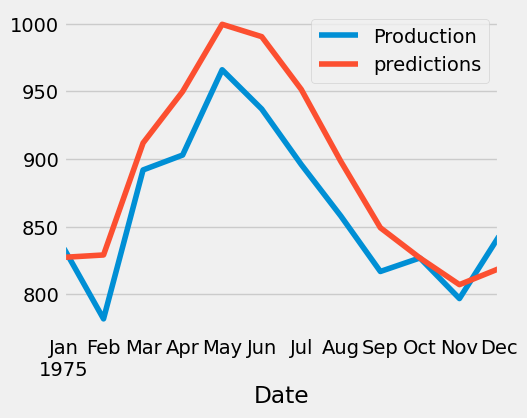

In [ ]:
test.plot(figsize=(5,4))

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rsme=sqrt(mean_squared_error(test['Production'],test['predictions']))
print(rsme)

35.6863570012855
